In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from functions import loc2data, get_rand_locs
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torch.utils.data import DataLoader, TensorDataset

In [3]:
training = np.load('training_inpainter_20240703.npz')

In [4]:
class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=0),
            nn.ReLU()  # Use Sigmoid if images are normalized to [0, 1]
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# Incomplete images (with holes)
raw_incomplete = training['data']
raw_incomplete_channels = np.expand_dims(raw_incomplete, axis=1)
data_incomplete = np.repeat(raw_incomplete_channels, repeats=3, axis=1)  # Replace with actual data

# Complete images (ground truth)
raw_complete = training['complete']
raw_complete_channels = np.expand_dims(raw_complete, axis=1)
data_complete = np.repeat(raw_complete_channels, repeats=3, axis=1)

# Masks
raw_masks = training['source_masks']
masks_channels = np.expand_dims(raw_masks, axis=1)
masks = np.repeat(masks_channels, repeats=3, axis=1)
#masks[masks != 0] = 1

# Convert to PyTorch tensors
data_incomplete = torch.tensor(data_incomplete, dtype=torch.float32)
data_complete = torch.tensor(data_complete, dtype=torch.float32)


# Split data into training and testing sets
from sklearn.model_selection import train_test_split

masks_train = masks[:700]
masks_val = masks[700:850]
masks_test = masks[850:]

#X_train, X_test, y_train, y_test = train_test_split(data_incomplete, data_complete, test_size=0.2)

X_train, X_temp, y_train, y_temp = train_test_split(data_incomplete, data_complete, test_size=0.3)

# Split remaining data into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train, torch.tensor(masks_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, torch.tensor(masks_val)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test, torch.tensor(masks_test)), batch_size=batch_size, shuffle=False)

In [22]:
# Initialize model, loss function, and optimizer
model = InpaintingAutoencoder()  
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=5e-4)

start_time = time.time()

losses_arr_cnn = []
epochs_arr_cnn = []
val_losses_arr_cnn = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    epochs_arr_cnn.append(epoch)
    model.train()
    running_loss = 0.0
    for incomplete, complete, masks in train_loader:
        #incomplete, complete = incomplete.cuda(), complete.cuda()
        
        optimizer.zero_grad()
        outputs = model(incomplete)
        
        loss = criterion(outputs, complete)
        loss = loss * masks.float()  # Compute loss only on the hole regions
        loss = loss.mean()
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if ((epoch+1) % 10 == 0):
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    losses_arr_cnn.append(epoch_loss)
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        for incomplete, complete, masks in val_loader:
            val_outputs = model(incomplete)
            val_loss = criterion(val_outputs, complete)
            val_loss = val_loss * masks.float()  # Compute loss only on the hole regions
            val_loss = val_loss.mean()
    
    val_losses_arr_cnn.append(val_loss.item())

training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')

Epoch 10/200, Loss: 0.0406
Epoch 20/200, Loss: 0.0243
Epoch 30/200, Loss: 0.0599
Epoch 40/200, Loss: 0.0263
Epoch 50/200, Loss: 0.0333
Epoch 60/200, Loss: 0.0225
Epoch 70/200, Loss: 0.0245
Epoch 80/200, Loss: 0.0225
Epoch 90/200, Loss: 0.0217
Epoch 100/200, Loss: 0.0861
Epoch 110/200, Loss: 0.0260
Epoch 120/200, Loss: 0.0221
Epoch 130/200, Loss: 0.0351
Epoch 140/200, Loss: 0.0224
Epoch 150/200, Loss: 0.0221
Epoch 160/200, Loss: 0.0212
Epoch 170/200, Loss: 0.0210
Epoch 180/200, Loss: 0.0620
Epoch 190/200, Loss: 0.0261
Epoch 200/200, Loss: 0.0227
Training time: 1112.29 seconds


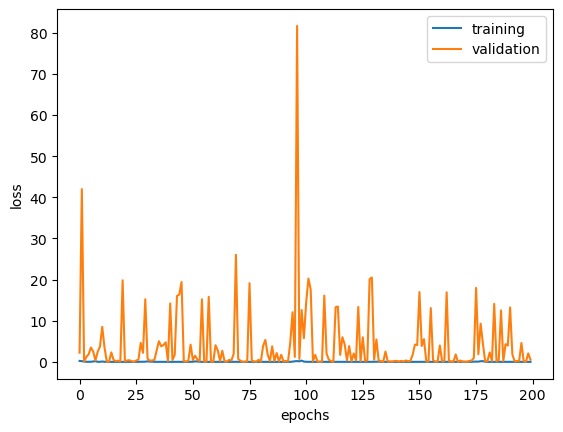

In [25]:
plt.plot(epochs_arr_cnn, losses_arr_cnn, label='training')
plt.plot(epochs_arr_cnn, val_losses_arr_cnn, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
# Validate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for incomplete, complete, masks in test_loader:
        outputs = model(incomplete)

        loss = criterion(outputs, complete)
        loss = loss * masks.float()
        loss = loss.mean()

        test_loss += loss.item()

print(f"Validation Loss: {test_loss / len(test_loader):.4f}")

Validation Loss: 1.2166


(82, 82)


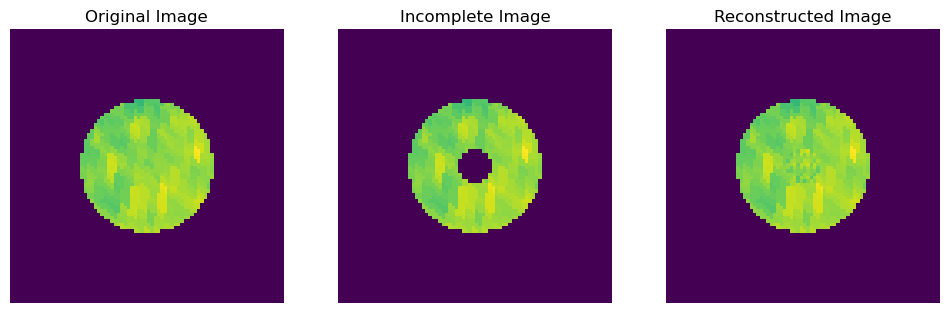

In [28]:
model.eval()
with torch.no_grad():
    for images, targets, masks in test_loader:
        outputs = model(images)
        #plt.imshow(masks[0,0])
        # Combine reconstructed holes with the original incomplete image
        reconstructed = images * (~masks) + outputs * masks
        # Transpose the images to make them suitable for plt.imshow
        original_image = targets[0, 0].cpu().squeeze().numpy()
        incomplete_image = images[0, 0].cpu().squeeze().numpy()
        reconstructed_image = reconstructed[0, 0].cpu().squeeze().numpy()
        
        print(reconstructed_image.shape)
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        # Show some results (example for the first image in the batch)
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        axes[1].imshow(incomplete_image)
        axes[1].set_title("Incomplete Image")
        axes[1].axis('off')
        
        axes[2].imshow(reconstructed_image)
        axes[2].set_title("Reconstructed Image")
        axes[2].axis('off')
        
        plt.show()
        break

In [29]:
with torch.no_grad():
    n = 200
    predictions = []
    originals = []
    inputs = []
    reconstructed = []
    resid_ims = []
    for batch_X, batch_y, masks in test_loader:
        pred = model(batch_X).numpy()
        image = model(batch_X)
        filled = batch_X * (~masks) + image * masks
        predictions.append(pred)
        originals.append(batch_y.numpy())
        inputs.append(batch_X.numpy())
        reconstructed.append(filled.numpy())
        resid_ims.append(batch_y.numpy() - filled.numpy())
        if len(predictions) * batch_size >= n:
            break
    predictions = np.concatenate(predictions)[:n]
    originals = np.concatenate(originals)[:n]
    inputs = np.concatenate(inputs)[:n]
    reconstructed = np.concatenate(reconstructed)[:n]
    resid_ims = np.concatenate(resid_ims)[:n]

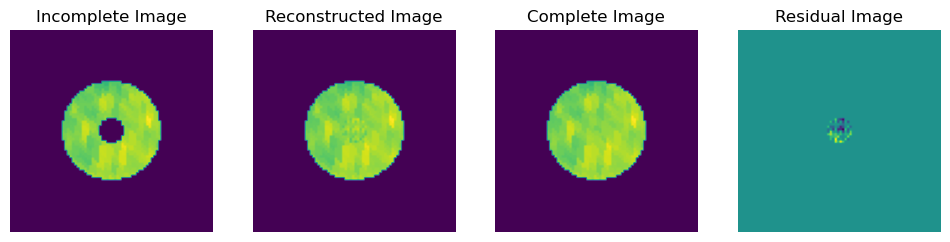

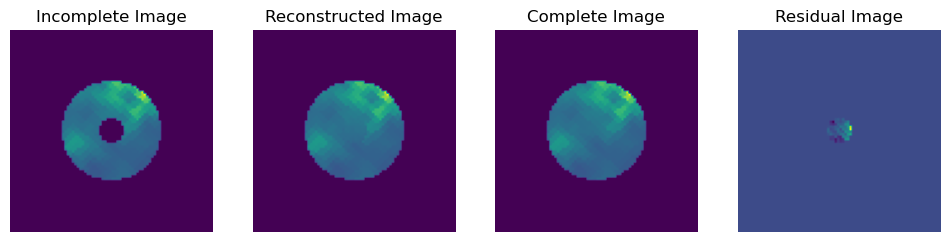

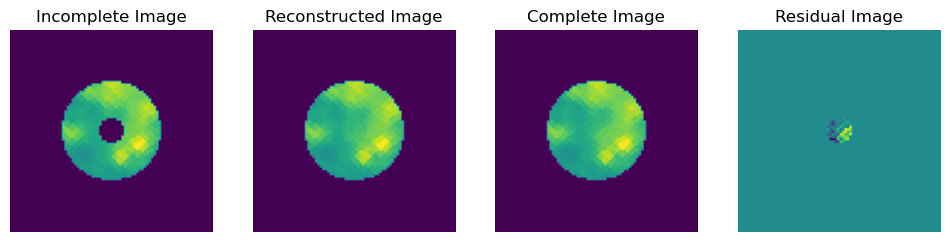

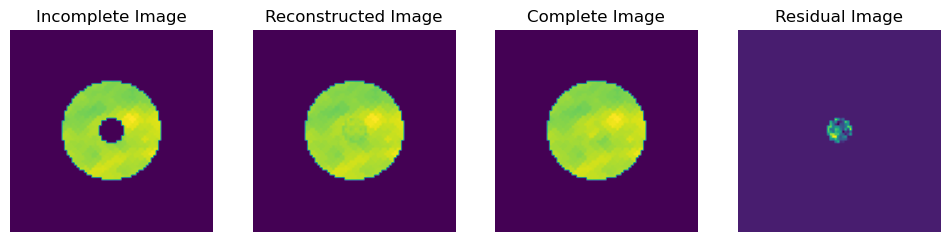

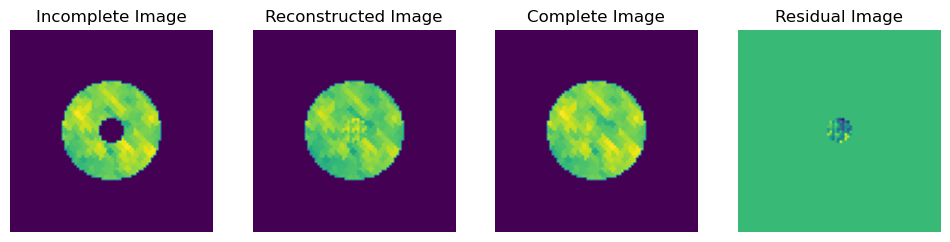

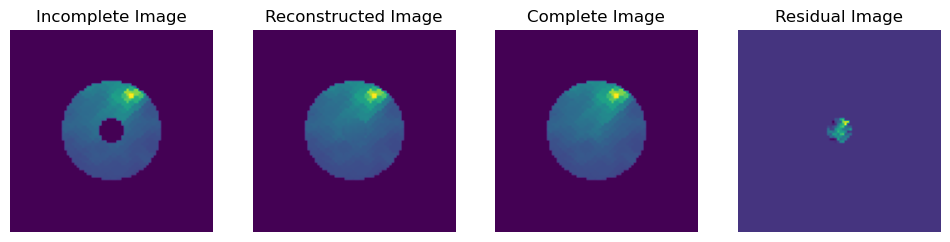

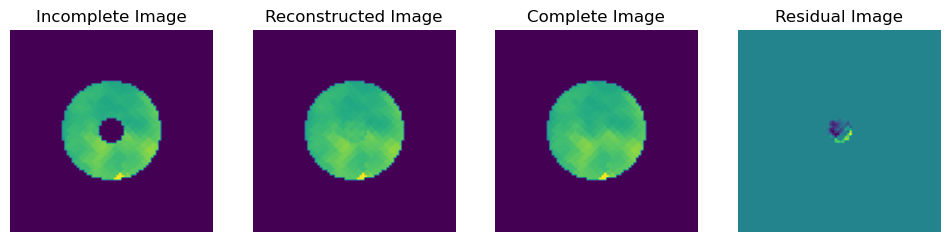

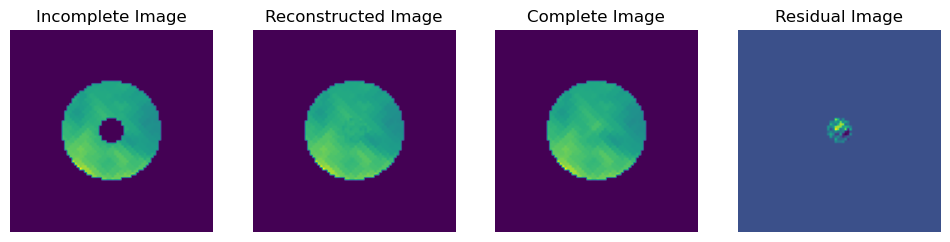

In [30]:
for i in range(8):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    axes[0].imshow(inputs[i, 0])
    axes[0].set_title('Incomplete Image')
    axes[0].axis('off')

    axes[1].imshow(reconstructed[i, 0])
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    axes[2].imshow(originals[i, 0])
    axes[2].set_title('Complete Image')
    axes[2].axis('off')
    
    axes[3].imshow(resid_ims[i, 0])
    axes[3].set_title('Residual Image')
    axes[3].axis('off')

    plt.show()

In [32]:
x = np.arange(82) - 40.5
y = np.arange(82) - 40.5
xv, yv = np.meshgrid(x, y)
mask_1 = (xv**2+yv**2)<20**2
mask_2 = (xv**2+yv**2)<5**2

In [33]:
pred_sources_raw = predictions
mean_pred_across_channels = np.mean(pred_sources_raw, axis=1)
mean_pred_across_channels = mean_pred_across_channels*mask_2

In [34]:
mean_pred_across_channels[mean_pred_across_channels == 0] = np.nan

In [35]:
pred_means = np.nanmean(mean_pred_across_channels, axis=(1, 2))

In [36]:
sources = originals - inputs

In [37]:
mean_true_across_channels = np.mean(sources, axis=1)

In [38]:
mean_true_across_channels[mean_true_across_channels == 0] = np.nan

In [39]:
true_means = np.nanmean(mean_true_across_channels, axis=(1, 2))

Text(0.5, 1.0, 'estimated vs true means of source image using CNN')

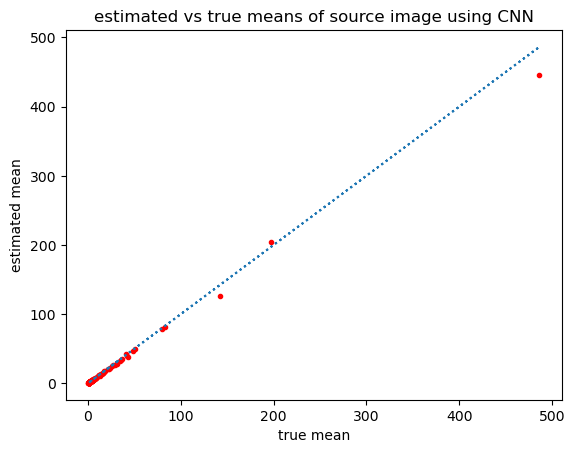

In [40]:
plt.scatter(true_means, pred_means, marker='.', color = 'red')
plt.plot(true_means, true_means, linestyle = 'dotted')
#plt.xlim(-10, 600)
#plt.ylim(-10, 600)
plt.xlabel('true mean')
plt.ylabel('estimated mean')
plt.title('estimated vs true means of source image using CNN')

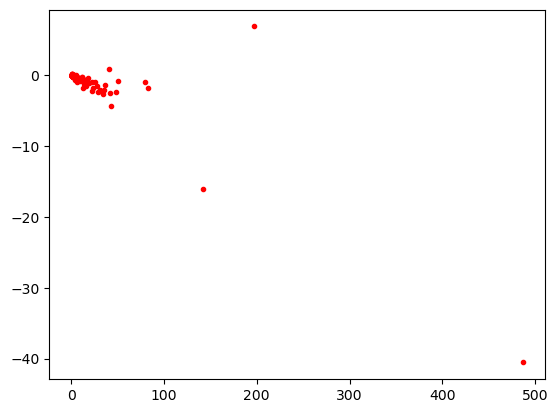

In [41]:
resid = pred_means - true_means
plt.scatter(true_means, resid, color='red', marker='.')

Text(0.5, 1.0, 'residual (true - predicted)')

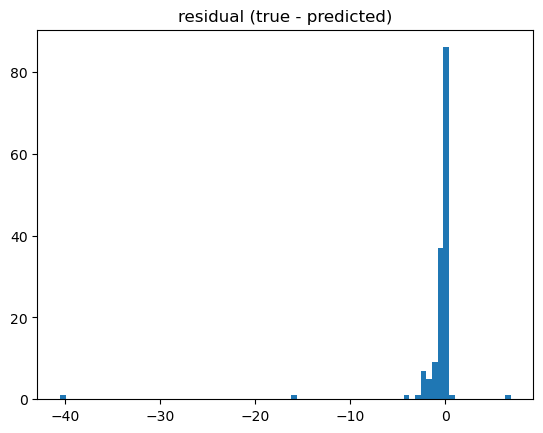

In [42]:
plt.hist(resid, bins=80)
#plt.xlim(-1,4)
plt.title('residual (true - predicted)')

In [44]:
mean_pred_across_channels.shape

(150, 82, 82)

In [45]:
# don't run this! for before i made a validation set
RMS = []
for i in range(200):
    summation = 0
    num_pix = len((np.where(raw_masks[0] == True))[0])
    masked = mean_pred_across_channels[i] * raw_masks[0]
    masked[np.isnan(masked)] = 0
    #print(masked[0])
    #print(np.where(np.isnan(masked[0])))
    #print("what", masked[0][0])
    for row in range(82):
        for col in range(82):
            summation += (masked[row][col]**2)
    #print(summation)
    curr_rms = np.sqrt(summation / num_pix)   
    RMS.append(curr_rms)

In [46]:
# use this instead
RMS2 = []
for i in range(150):
    summation = 0
    num_pix = len((np.where(raw_masks[0] == True))[0])
    masked = raw_complete[850+i] * raw_masks[0]
    #masked[np.isnan(masked)] = 0
    #print(masked[0])
    #print(np.where(np.isnan(masked[0])))
    #print("what", masked[0][0])
    for row in range(82):
        for col in range(82):
            summation += (masked[row][col]**2)
    #print(summation)
    curr_rms = np.sqrt(summation / num_pix)   
    RMS2.append(curr_rms)

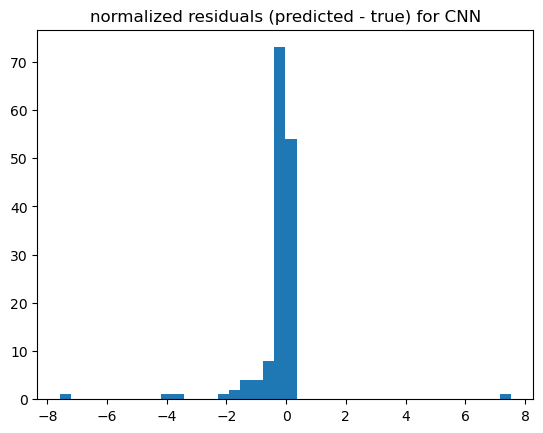

In [47]:
plt.hist(resid/RMS2, bins = 40)
plt.title('normalized residuals (predicted - true) for CNN')
plt.show()

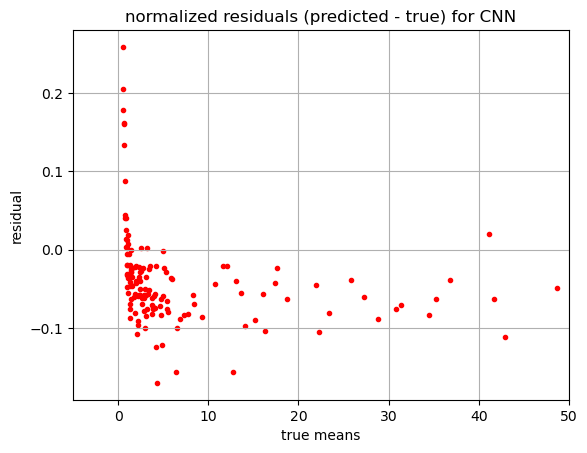

In [48]:
plt.scatter(true_means, resid/RMS, marker='.', color='red')
plt.title('normalized residuals (predicted - true) for CNN')
plt.xlabel('true means')
plt.ylabel('residual')
plt.xlim(-5, 50)
plt.grid()
plt.show()

In [49]:
# neural net

#NN time
true_sources = training['complete'] - training['data']
true_sources[np.isnan(true_sources)] = 0

X = training['data']
y = np.nanmean(true_sources, axis=(1, 2))

# Parameters
array_size = 82
test_size = 0.2
batch_size = 32
epochs = 200
epoch_arr_nn = []
loss_arr_nn = []
learning_rate = 0.001

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the neural network model
class MeanEstimator(nn.Module):
    def __init__(self):
        super(MeanEstimator, self).__init__()
        self.fc1 = nn.Linear(array_size * array_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = MeanEstimator()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

# Training loop
for epoch in range(epochs):
    epoch_arr_nn.append(epoch)
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_arr_nn.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')
        
# Evaluation
test_losses_nn = []
test_x_nn = []
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    #print(test_loss)
    print(f'Test Loss: {test_loss.item():.4f}')

# Compare some predictions with the actual mean values
with torch.no_grad():
    predictions = model(X_test)
    for i in range(5):
        print(f'Predicted mean: {predictions[i].item():.4f}, Actual mean: {y_test[i].item():.4f}')



Epoch [20/200], Loss: 4.2784
Epoch [40/200], Loss: 0.1301
Epoch [60/200], Loss: 0.1131
Epoch [80/200], Loss: 0.0235
Epoch [100/200], Loss: 0.0126
Epoch [120/200], Loss: 0.0091
Epoch [140/200], Loss: 0.0078
Epoch [160/200], Loss: 0.0069
Epoch [180/200], Loss: 0.0061
Epoch [200/200], Loss: 0.0054
Training time: 1.31 seconds
Test Loss: 0.0052
Predicted mean: 0.0724, Actual mean: 0.0164
Predicted mean: 0.0777, Actual mean: 0.0204
Predicted mean: 0.0950, Actual mean: 0.0406
Predicted mean: 0.1091, Actual mean: 0.0633
Predicted mean: 0.0760, Actual mean: 0.0215


In [50]:
test_losses_nn = np.sqrt(abs(y_test**2 - predictions**2))
text_x_nn = np.linspace(0, 200)

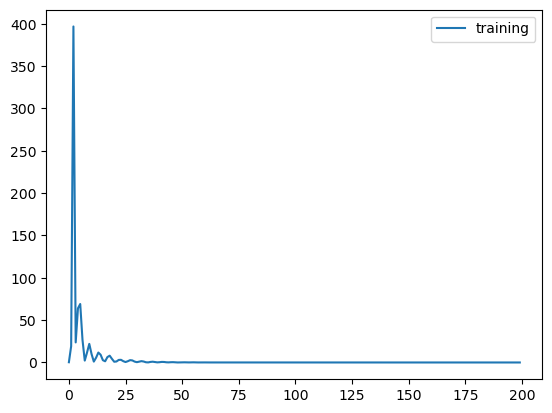

In [51]:
plt.plot(epoch_arr_nn, loss_arr_nn, label='training')
plt.legend()
plt.show()

In [52]:
# neural net w validation
true_sources = training['complete'] - training['data']
true_sources[np.isnan(true_sources)] = 0

X = training['data']
y = np.nanmean(true_sources, axis=(1, 2))

# Parameters
array_size = 82
test_size = 0.2
batch_size = 32
epochs = 200
epoch_arr_nn = []
loss_arr_nn = []
val_loss_arr_nn = []
learning_rate = 0.001

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# Step 2: Split remaining data into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Define the neural network model
class MeanEstimator(nn.Module):
    def __init__(self):
        super(MeanEstimator, self).__init__()
        self.fc1 = nn.Linear(array_size * array_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = MeanEstimator()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

# Training loop
for epoch in range(epochs):
    epoch_arr_nn.append(epoch)
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_arr_nn.append(loss.item())
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    val_loss_arr_nn.append(val_loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')
        
# Evaluation
test_losses_nn = []
test_x_nn = []
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    #print(test_loss)
    print(f'Test Loss: {test_loss.item():.4f}')

# Compare some predictions with the actual mean values
with torch.no_grad():
    predictions = model(X_test)
    for i in range(5):
        print(f'Predicted mean: {predictions[i].item():.4f}, Actual mean: {y_test[i].item():.4f}')

Epoch [50/200], Loss: 0.0277
Epoch [100/200], Loss: 0.0025
Epoch [150/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0010
Training time: 1.32 seconds
Test Loss: 0.0041
Predicted mean: 0.1404, Actual mean: 0.1179
Predicted mean: 0.0576, Actual mean: 0.0420
Predicted mean: 0.0570, Actual mean: 0.0410
Predicted mean: 0.0364, Actual mean: 0.0196
Predicted mean: 0.0398, Actual mean: 0.0248


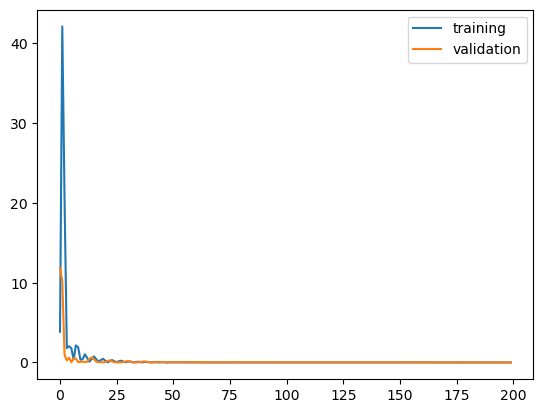

In [53]:
plt.plot(epoch_arr_nn, loss_arr_nn, label='training')
plt.plot(epoch_arr_nn, val_loss_arr_nn, label='validation')
plt.legend()
plt.show()

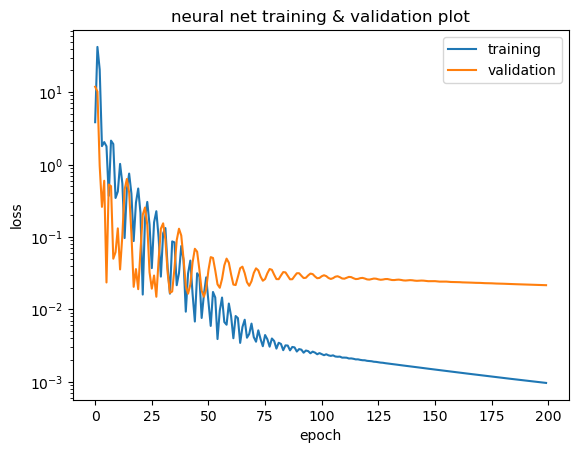

In [54]:
plt.plot(epoch_arr_nn, loss_arr_nn, label='training')
plt.plot(epoch_arr_nn, val_loss_arr_nn, label='validation')
plt.yscale('log')
plt.legend()
plt.title('neural net training & validation plot')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [55]:
resid_arr_nn = predictions.numpy().flatten() - y_test.numpy().flatten()

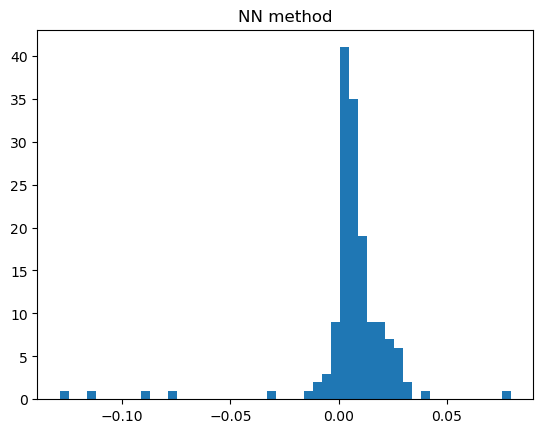

In [56]:
plt.hist(resid_arr_nn / RMS2, bins = 50)
plt.title('NN method')
plt.show()

In [57]:
sources_arr = training['source']
sources_arr[sources_arr == 0] = np.nan
annulus_arr = training['data']
annulus_arr[annulus_arr == 0] = np.nan
annulus_arr_mean = np.nanmean(annulus_arr, axis=(1,2))
sources_arr_mean = np.nanmean(sources_arr, axis=(1,2))
resid_noML = annulus_arr_mean - sources_arr_mean

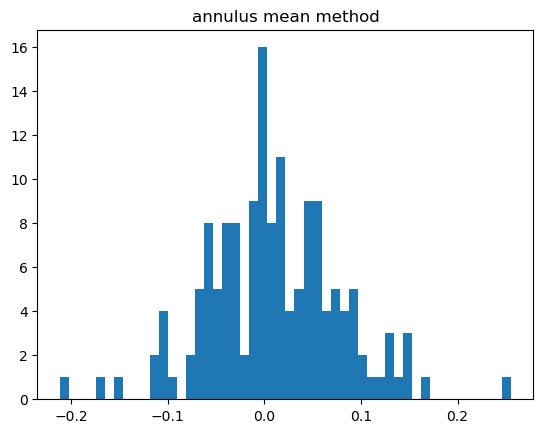

In [58]:
plt.hist(resid_noML[850:]/RMS2, bins = 50)
plt.title('annulus mean method')
plt.show()

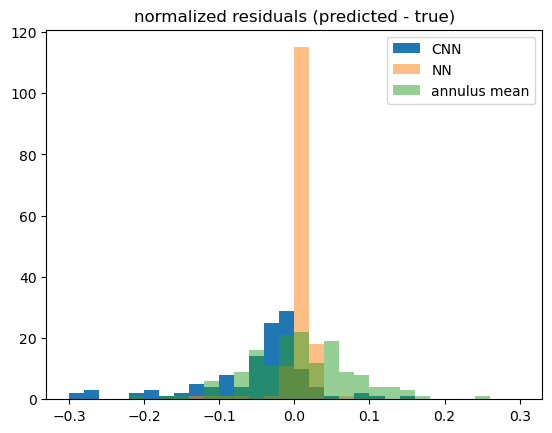

In [60]:
plt.hist(resid/RMS2, bins = 30, label='CNN', alpha=1.0, range=(-0.3,0.3))
plt.hist(resid_arr_nn / RMS2, bins = 30, label='NN', alpha=0.5, range=(-0.3,0.3))
plt.hist(resid_noML[850:]/RMS2, bins = 30, label='annulus mean', alpha=0.5, range=(-0.3,0.3))
#plt.xlim(-0.3, 0.3)
plt.title('normalized residuals (predicted - true)')
plt.legend()
plt.show()

In [61]:
np.where( (resid / RMS) < -0.3 )

(array([], dtype=int64),)

In [62]:
# doing stats
constrained_resid_nn = np.copy(resid_arr_nn/RMS2)
constrained_resid_nn[constrained_resid_nn>0.3] = np.nan
constrained_resid_nn[constrained_resid_nn<-0.3] = np.nan
constrained_nn_mean = np.nanmean(constrained_resid_nn)

# mean abs dev calculations
mean_nn = np.mean(resid_arr_nn/RMS2)
sum_nn = 0
num_nn = 0
for x in (resid_arr_nn/RMS2):
    #if x >= -0.2 and x <= 0.2:
        sum_nn += abs(x - mean_nn)
        #sum_nn += abs(x - constrained_nn_mean)
        num_nn += 1
mean_abs_dev_nn = sum_nn/num_nn

constrained_resid_cnn = np.copy(resid/RMS)
constrained_resid_cnn[constrained_resid_cnn>0.3] = np.nan
constrained_resid_cnn[constrained_resid_cnn<-0.3] = np.nan
constrained_cnn_mean = np.nanmean(constrained_resid_cnn)

mean_cnn = np.mean(resid/RMS2)
sum_cnn = 0
num_cnn = 0
for x in (resid/RMS2):
    #if x >= -0.3 and x <= 0.3:
        sum_cnn += abs(x - mean_cnn)
        #sum_cnn += abs(x - constrained_cnn_mean)
        num_cnn += 1
mean_abs_dev_cnn = sum_cnn/num_cnn

constrained_resid_noML = np.copy(resid_noML[850:]/RMS2)
constrained_resid_noML[constrained_resid_noML>0.3] = np.nan
constrained_resid_noML[constrained_resid_noML<-0.3] = np.nan
constrained_noML_mean = np.nanmean(constrained_resid_noML)

mean_noML = np.mean(resid_noML[850:]/RMS2)
sum_noML = 0
num_noML = 0
for x in (resid_noML[850:]/RMS2):
    #if x >= -0.2 and x <= 0.2:
        sum_noML += abs(x - mean_noML)
        #sum_noML += abs(x - constrained_noML_mean)
        num_noML += 1
mean_abs_dev_noML = sum_noML/num_noML



In [63]:
RMS_CNN = 0
rms_sum_cnn = 0
rms_num_cnn = 0
for val in (resid/RMS2):
    #if val >= -0.3 and val <= 0.3:
        rms_sum_cnn += np.power(val, 2)
        rms_num_cnn += 1
        #print(val)
RMS_CNN = np.sqrt(rms_sum_cnn / rms_num_cnn)

rms_sum_nn = 0
rms_num_nn = 0
for val in (resid_arr_nn/RMS2):
    #if val >= -0.3 and val <= 0.3:
        rms_sum_nn += val**2
        rms_num_nn += 1
RMS_NN = np.sqrt(rms_sum_nn / rms_num_nn)

rms_sum_noML = 0
rms_num_noML = 0
for val in (resid_noML[850:]/RMS2):
    #if val >= -0.3 and val <= 0.3:
        rms_sum_noML += val**2
        rms_num_noML += 1
RMS_noML = np.sqrt(rms_sum_noML / rms_num_noML)

In [64]:
print("Root Mean Square")
print("CNN: ", RMS_CNN)
print("NN: ", RMS_NN)
print("No ML: ", RMS_noML)
print("\n")
print("Mean Absolute Dev")
print("CNN: ", mean_abs_dev_cnn)
print("NN: ", mean_abs_dev_nn)
print("No ML: ", mean_abs_dev_noML)

Root Mean Square
CNN:  1.0551120835753347
NN:  0.022038941613203366
No ML:  0.06884373993420385


Mean Absolute Dev
CNN:  0.3913408260878256
NN:  0.010097675843633691
No ML:  0.05210483390114746
